In [1]:
import pandas as pd
import numpy as np

import time
from datetime import datetime, timedelta
import pytz

In [30]:
# Years 1998, 1999, and 2000. 2001 doesn't exist. And, 1997 and earlier are much harder to deal with.
def make_date_time_col(df, YEAR):
    
    if YEAR not in [1998, 1999, 2000]:
        return df
    date_time = []
    for idx in df.index:
        
        dt = datetime(df.loc[idx, 'YEAR'], df.loc[idx, 'M'], df.loc[idx, 'D'], df.loc[idx, 'HR']-1)
        date_time.append(dt+timedelta(hours=1))
    df['Hour_End'] = date_time
    return df


# Deal with some poor datatime formatting.
# Some hours extend to 24:00 instead of 0:00 - 23:59
def standardize_datetime(date_str):
    
    # Check format of the strings:
    fmt = '%Y-%m-%d %H:%M:%S' if '-' in date_str else '%m/%d/%Y %H:%M'
    
    # Newer years denote the change of daylight savings time
    date_str = date_str.strip(' DST')
    
    # Strip decimal seconds
    date_str = date_str.split('.')[0]
    
    if '24:00' in date_str:
        #print(f'orig: {date_str}')
        date_str = date_str.replace('24:00', '23:00')
        new_dt = datetime.strptime(date_str, fmt)
        new_dt = new_dt+timedelta(hours=1)
        #print(f'final: {new_dt}')
    else:
        new_dt = datetime.strptime(date_str, fmt)
    
    return new_dt

# Set timezone and convert to UTC
# default timezone for TEXAS
def set_timezone(dt, is_dt_dst, zone='US/Central'):
    #print(dt)
    timezone = pytz.timezone(zone)
    new_dt = timezone.localize(dt, is_dst=is_dt_dst)
    #print(new_dt)
    new_dt = new_dt.astimezone(pytz.utc)
    #print(new_dt)
    return new_dt
    



def check_is_dst(df, year, dt_col):
    
    is_dt_dst = False # All TX years start with January (not daylight savings time)
    
    # 1998, 1999, 2000 already have datetime format
    if year > 2001:
        dts = []
        for idx in df.index:
            as_str = df.loc[idx, dt_col]
        
            dts.append(standardize_datetime(as_str))
        
        df[dt_col] = dts
        # Need to round before making daylight savings comparisons
        df[dt_col] = pd.to_datetime(df[dt_col]).dt.round('H')
    
    prev = ''
    new_dts = []
    for idx in df.index:
        as_dt = df.loc[idx, dt_col]
        
        # Get prev set to work below
        if prev == '':
            prev = as_dt+timedelta(hours=-1)
        
        
        # Find daylight savings time boundaries
        # Identical values are during Fall's fall back (exiting daylight savings)
        if as_dt == prev:
            print(f" -- two identicals at: {idx} with values {prev}")
            #print(f" ---- previous     {df.loc[idx-2, dt_col]}, {df.loc[idx-1, dt_col]}")
            #print(f" ---- previous UTC {new_dts[-2]}, {new_dts[-1]}")
            if new_dts[-2] == new_dts[-1] + timedelta(hours=-2):
                new_dts[-1] = new_dts[-1] + timedelta(hours=-1)
            is_dt_dst = False
        # Skipping values is spring forward (entering daylight savings)
        elif as_dt == prev+timedelta(hours=2):
            print(f" -- dst: {idx} with values {prev}, {as_dt}")
            is_dt_dst = True
        elif as_dt != prev+timedelta(hours=1):
            print(f"\n -- STRANGE GAP: {idx} with values {prev}, {as_dt}")
        prev = as_dt
        
        final_dt = set_timezone(as_dt, is_dt_dst, 'US/Central')
        new_dts.append(final_dt)
    df['date_time UTC'] = new_dts
        
    return df
        
        
first = True
prep_mem = False
for YEAR in range(1998, 2020):
    
    
    if prep_mem:
        continue
    print(YEAR)
    
    # 2001 data year is missing from ERCOT data
    if YEAR == 2001:
        print("skipping 2001")
        continue

     
    if YEAR <= 2001:
        TYPE = 'csv'
    elif YEAR <= 2015:
        TYPE = 'xls'
    else:
        TYPE = 'xlsx'
    
    
    if YEAR <= 2001:
        df = pd.read_csv(f'/Users/truggles/Downloads/ERCOT_DEMAND/{YEAR}_ERCOT_Hourly_Load_Data.{TYPE}',
                        dtype={'ERCOT': float, 'Hour_End': str})
        df = make_date_time_col(df, YEAR)
    else:
        df = pd.read_excel(f'/Users/truggles/Downloads/ERCOT_DEMAND/{YEAR}_ERCOT_Hourly_Load_Data.{TYPE}',
                        dtype={'ERCOT': float, 'Hour_End': str})
    
    
    df = check_is_dst(df, YEAR, 'Hour_End')
        
        
    # Years 1998, 1999, 2000 are in kw, not MW
    if YEAR in [1998, 1999, 2000]:
        #df['ERCOT'] = df['ERCOT'].astype(float)
        #df['ERCOT'] = pd.to_numeric(df['ERCOT'],errors='coerce')
        df['ERCOT'] = df['ERCOT'] / 1000.
        
    #print(df.head())
    print(f' - {len(df.index)}')
    
    if first:
        master = df[['Hour_End', 'date_time UTC', 'ERCOT']]
        master_cols = list(master.columns)
    else:
        #if master_cols != list(df.columns):
        #    print(master_cols)
        #    print(list(df.columns))
        #    print("Yikes")
        df = df[['Hour_End', 'date_time UTC', 'ERCOT']]
        master = master.append(df)
        print(f' - {len(master.index)}')
    first = False

if not prep_mem:
    master.to_csv('tmp5.csv', index=False)

    

1998
 -- dst: 2257 with values 1998-04-05 01:00:00, 1998-04-05 03:00:00
 -- two identicals at: 7129 with values 1998-10-25 02:00:00
 - 8760
1999
 -- dst: 2234 with values 1999-04-04 02:00:00, 1999-04-04 04:00:00
 -- two identicals at: 7273 with values 1999-10-31 02:00:00
 - 8760
 - 17520
2000
 -- dst: 2210 with values 2000-04-02 02:00:00, 2000-04-02 04:00:00
 -- two identicals at: 7249 with values 2000-10-29 02:00:00
 - 8784
 - 26304
2001
skipping 2001
2002
 -- dst: 2305 with values 2002-04-07 01:00:00, 2002-04-07 03:00:00
 -- two identicals at: 7177 with values 2002-10-27 02:00:00
 - 8760
 - 35064
2003
 -- dst: 2281 with values 2003-04-06 01:00:00, 2003-04-06 03:00:00
 -- two identicals at: 7153 with values 2003-10-26 02:00:00
 - 8760
 - 43824
2004
 -- dst: 2257 with values 2004-04-04 01:00:00, 2004-04-04 03:00:00
 -- two identicals at: 7297 with values 2004-10-31 02:00:00
 - 8784
 - 52608
2005
 -- dst: 2209 with values 2005-04-03 01:00:00, 2005-04-03 03:00:00
 -- two identicals at: 7

In [32]:
# Add MEM date/time columns and select the target demand region
def prep_mem(f_name, tgt_dem_col):
    
    df = pd.read_csv(f_name)
    df['Hour_End'] = pd.to_datetime(df['date_time UTC'])
    print(df.dtypes)
    
    years, months, days, hours = [], [], [], []
    for idx in df.index:
        dt = df.loc[idx, 'Hour_End'] + timedelta(hours=-1)
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
        hours.append(dt.hour + 1)
    
    new_df = pd.DataFrame({'year': years,
                           'month': months,
                           'day': days,
                           'hour': hours,
                           'demand (MW)': df[tgt_dem_col]})
    
    new_df.to_csv('new_tmp5_ERCOT_mem.csv', index=False)
    return

prep_mem('tmp5.csv', 'ERCOT')
    

Hour_End         datetime64[ns, UTC]
date_time UTC                 object
ERCOT                        float64
dtype: object


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


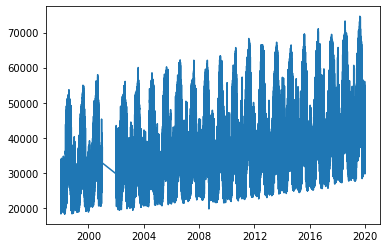

In [34]:
import matplotlib.pyplot as plt

df = pd.read_csv('tmp5.csv')
df['Hour_End'] = pd.to_datetime(df['Hour_End'])

fig, ax = plt.subplots()
ax.plot(df['Hour_End'], df['ERCOT'])
plt.show()